In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.regression.linear_model import OLS

In [30]:
data = pd.read_csv('../prcp_monthly.csv')
data['month'] = pd.to_datetime(data['month'])
data.head()

,index,month,prcp
0,0,2001-01-01,101.400000
1,1,2001-02-01,98.200000
2,2,2001-03-01,201.200000
3,3,2001-04-01,141.200000
4,4,2001-05-01,29.233333


## 1. Quarterly seasonality:

##### Quarterly data:

In [31]:
s1 = np.zeros(len(data))
s2 = np.zeros(len(data))
s3 = np.zeros(len(data))
s4 = np.zeros(len(data))

s1[(data['month'].dt.month >= 1) & (data['month'].dt.month <= 3)] = 1
s2[(data['month'].dt.month >= 4) & (data['month'].dt.month <= 6)] = 1
s3[(data['month'].dt.month >= 7) & (data['month'].dt.month <= 9)] = 1
s4[(data['month'].dt.month >= 10) & (data['month'].dt.month <= 12)] = 1

seasonal_data = data.copy()
seasonal_data['s1'] = s1
seasonal_data['s2'] = s2
seasonal_data['s3'] = s3
seasonal_data['s4'] = s4
seasonal_data['index2'] = seasonal_data['index']**2
seasonal_data['index3'] = seasonal_data['index']**3
seasonal_data.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

seasonal_data.head()

,index,month,prcp,s1,s2,s3,s4,index2,index3
2001-01-31,0,2001-01-01,101.400000,1.0,0.0,0.0,0.0,0,0
2001-02-28,1,2001-02-01,98.200000,1.0,0.0,0.0,0.0,1,1
2001-03-31,2,2001-03-01,201.200000,1.0,0.0,0.0,0.0,4,8
2001-04-30,3,2001-04-01,141.200000,0.0,1.0,0.0,0.0,9,27
2001-05-31,4,2001-05-01,29.233333,0.0,1.0,0.0,0.0,16,64


##### Train test split:

In [32]:
seasonal_train = seasonal_data[seasonal_data['month'].dt.year <= 2015]
seasonal_test = seasonal_data[seasonal_data['month'].dt.year > 2015]

#### Linear model:

`y_t = b_0*t + b_1*S_1 + b_2*S_2 + b_3*S_3 + b_4*S_4`

In [33]:
linear = OLS(seasonal_train['prcp'], seasonal_train[['index', 's1', 's2', 's3', 's4']]).fit()
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     61.30
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           2.68e-32
Time:                        11:21:41   Log-Likelihood:                -972.75
No. Observations:                 180   AIC:                             1955.
Df Residuals:                     175   BIC:                             1971.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.1232      0.078      1.571      0.118      -0.032       0.278
s1           184.4451     10.516     17.539      0.000     163.690     205.200
s2            67.9557     10.667      6.371      0.000      46.903      89.008
s3            22.7221     10.821      2.100      0.037       1.366      44.078
s4           145.7944     10.977     13.281      0.000     124.129     167.459
==============================================================================
Omnibus:                       40.252   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.317
Skew:                           1.045   Prob(JB):                     3.62e-18
Kurtosis:                       5.518   Cond. No.                         413.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Biến `t` không có nhiều ý nghĩa thống kê trong mô hình do p-value < 0.05

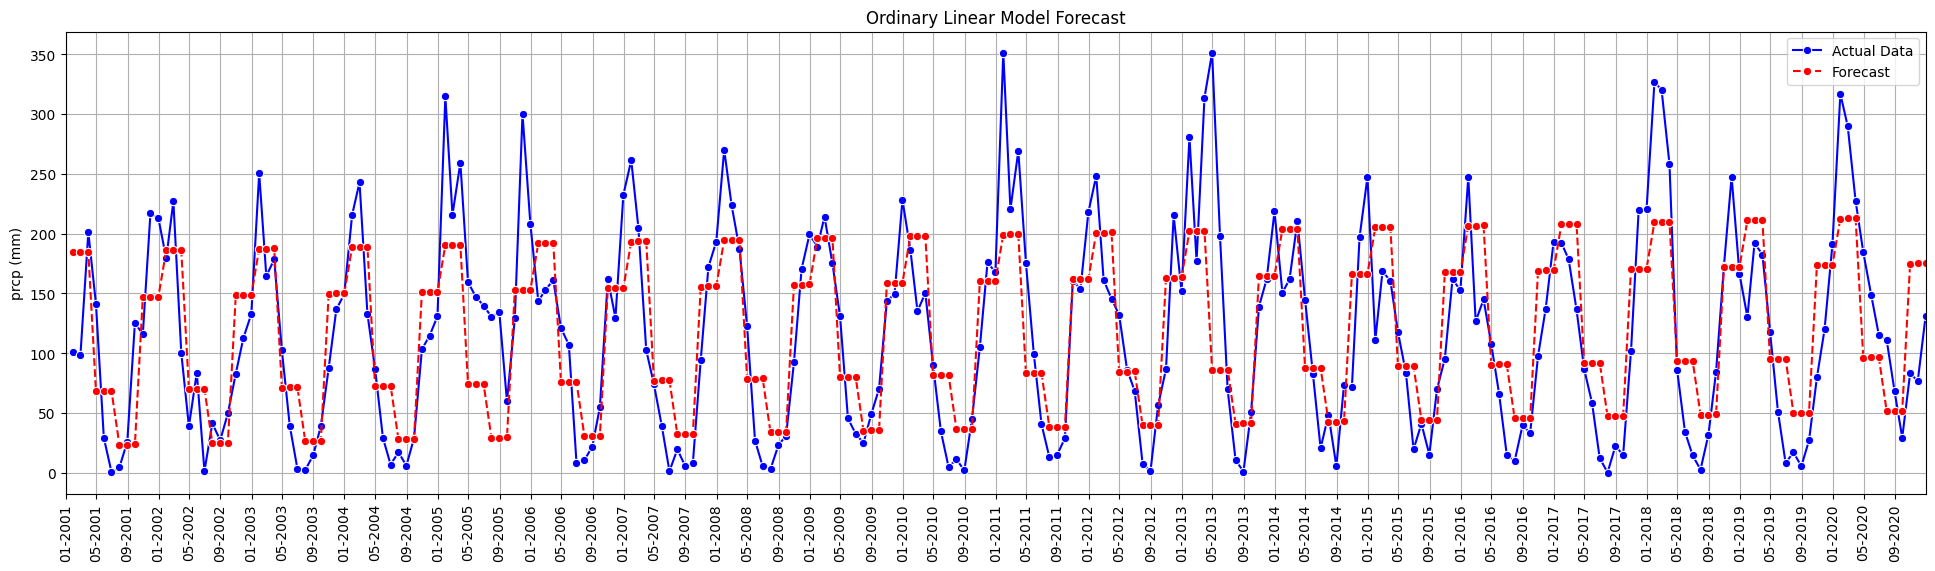

In [34]:
output = linear.predict(seasonal_data[['index', 's1', 's2', 's3', 's4']])
output_copy = pd.Series(output, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(seasonal_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Linear Model Forecast")
plt.legend()
# plt.savefig('../forecast/quaterly_ordinary_linear_model.png')
plt.show()

Evaluate:

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(seasonal_test['prcp'], output[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(seasonal_test['prcp'], output[-60:])
r2 = r2_score(seasonal_test['prcp'], output[-60:])
aic = linear.aic
bic = linear.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")


MSE: 3116.69
RMSE: 55.83
MAE: 47.12
R²: 0.605
AIC: 1955.50
BIC: 1971.46


### Quadratic model:

`y_t = b_0*t + b_1*t^2 + b_1*S_1 + b_2*S_2 + b_3*S_3 + b_4*S_4`

In [36]:
linear2 = OLS(seasonal_train['prcp'], seasonal_train[['index', 'index2', 's1', 's2', 's3', 's4']]).fit()
linear2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     49.50
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.06e-31
Time:                        11:22:35   Log-Likelihood:                -971.96
No. Observations:                 180   AIC:                             1956.
Df Residuals:                     174   BIC:                             1975.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.4947      0.311      1.591      0.114      -0.119       1.109
index2        -0.0021      0.002     -1.234      0.219      -0.005       0.001
s1           173.4412     13.774     12.592      0.000     146.255     200.628
s2            56.9145     13.909      4.092      0.000      29.463      84.366
s3            11.6809     14.027      0.833      0.406     -16.004      39.366
s4           134.7905     14.129      9.540      0.000     106.905     162.676
==============================================================================
Omnibus:                       41.669   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.667
Skew:                           1.073   Prob(JB):                     4.12e-19
Kurtosis:                       5.586   Cond. No.                     8.55e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Biến `t`, `t^2`, `s3` không có nhiều ý nghĩa thống kê trong mô hình do p-value < 0.05

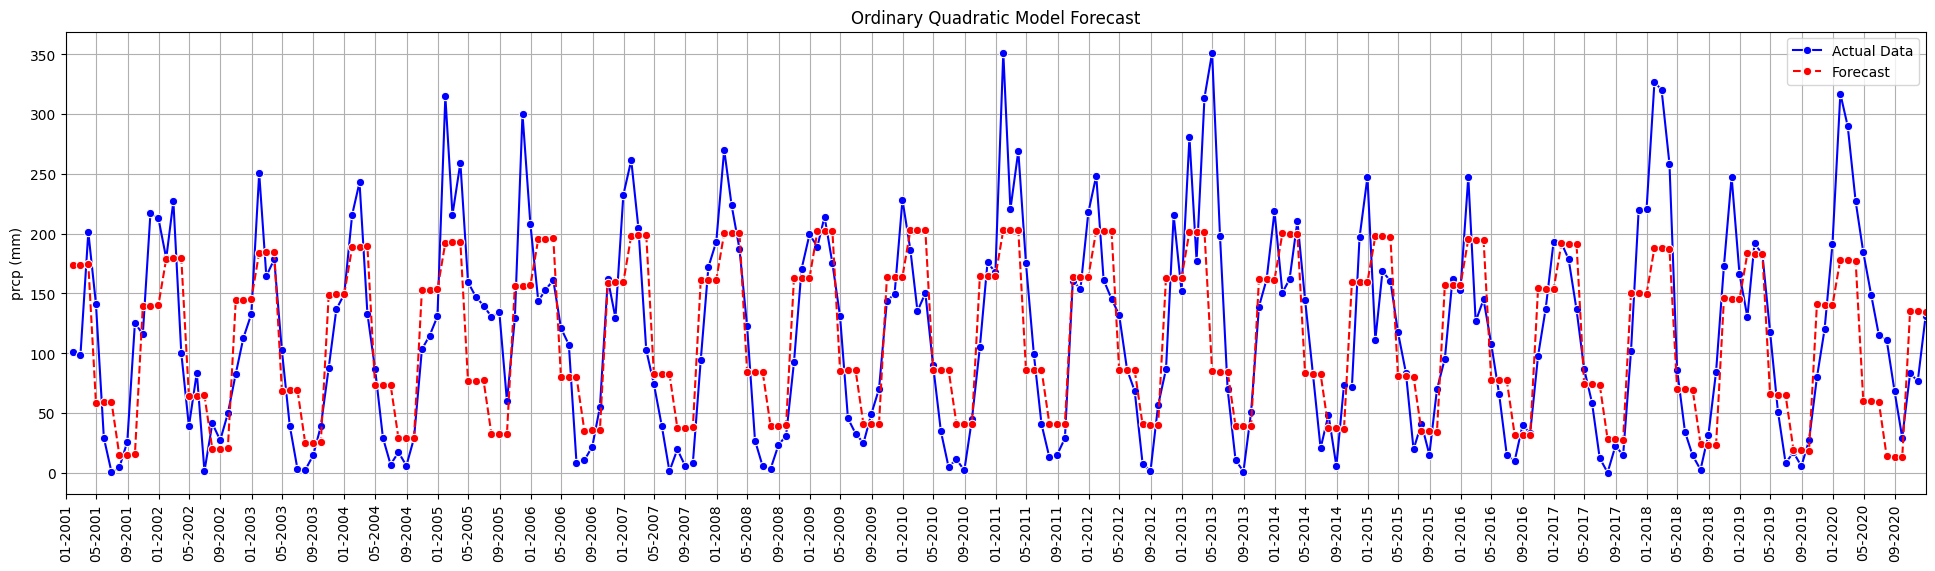

In [37]:
output2 = linear2.predict(seasonal_data[['index', 'index2', 's1', 's2', 's3', 's4']])
output2_copy = pd.Series(output2, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(seasonal_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output2_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Quadratic Model Forecast")
plt.legend()
# plt.savefig('../forecast/quarterly_ordinary_quadratic_model.png')
plt.show()

Evaluate:

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(seasonal_test['prcp'], output2[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(seasonal_test['prcp'], output2[-60:])
r2 = r2_score(seasonal_test['prcp'], output2[-60:])
aic = linear2.aic
bic = linear2.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 3310.82
RMSE: 57.54
MAE: 44.91
R²: 0.580
AIC: 1955.93
BIC: 1975.09


### Cubic model:

In [39]:
linear3 = OLS(seasonal_train['prcp'], seasonal_train[['index', 'index2', 'index3', 's1', 's2', 's3', 's4']]).fit()
linear3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     41.01
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           7.85e-31
Time:                        11:23:07   Log-Likelihood:                -971.96
No. Observations:                 180   AIC:                             1958.
Df Residuals:                     173   BIC:                             1980.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.4193      0.778      0.539      0.590      -1.116       1.954
index2        -0.0010      0.010     -0.101      0.920      -0.021       0.019
index3      -3.93e-06   3.71e-05     -0.106      0.916   -7.72e-05    6.94e-05
s1           174.4969     17.039     10.241      0.000     140.866     208.128
s2            58.0085     17.361      3.341      0.001      23.741      92.276
s3            12.8129     17.671      0.725      0.469     -22.066      47.692
s4           135.9608     17.973      7.565      0.000     100.486     171.436
==============================================================================
Omnibus:                       41.476   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.868
Skew:                           1.070   Prob(JB):                     6.14e-19
Kurtosis:                       5.569   Cond. No.                     1.72e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

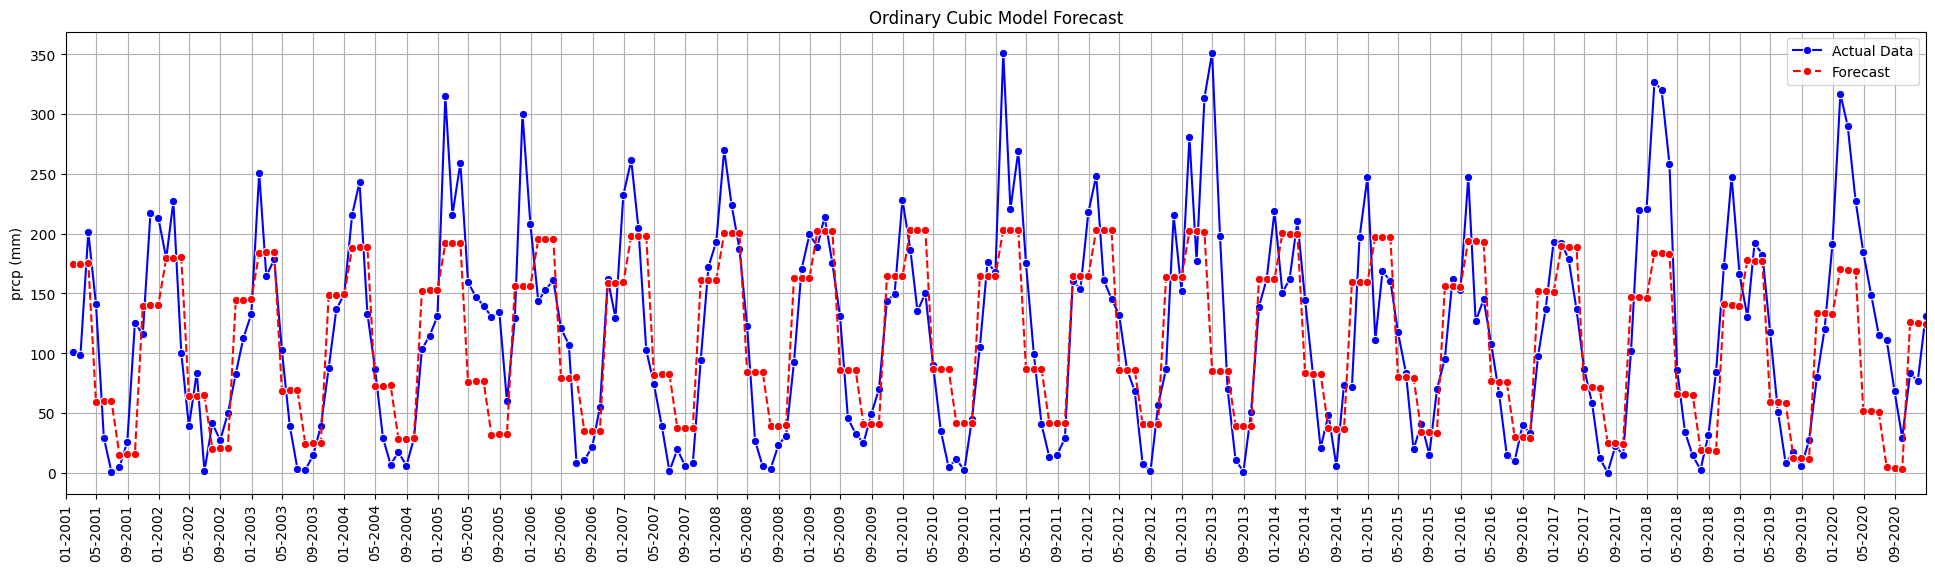

In [40]:
output3 = linear3.predict(seasonal_data[['index', 'index2', 'index3','s1', 's2', 's3', 's4']])
output3_copy = pd.Series(output3, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(seasonal_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output3_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Cubic Model Forecast")
plt.legend()
# plt.savefig('../forecast/quarterly_ordinary_cubic_model.png')
plt.show()

Evaluate:

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(seasonal_test['prcp'], output3[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(seasonal_test['prcp'], output3[-60:])
r2 = r2_score(seasonal_test['prcp'], output3[-60:])
aic = linear3.aic
bic = linear3.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 3545.96
RMSE: 59.55
MAE: 46.08
R²: 0.550
AIC: 1957.92
BIC: 1980.27


## 2. Monthly seasonality:

##### Monthly data:

In [42]:
dummy_months = [np.zeros(len(data)) for i in range(12)]

for i in range(12):
    dummy_months[i][(data['month'].dt.month == i+1)] = 1

monthly_data = data.copy()
for i in range(12):
    monthly_data[f'm{i+1}'] = dummy_months[i]
monthly_data['index2'] = monthly_data['index']**2
monthly_data['index3'] = monthly_data['index']**3
monthly_data.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

monthly_data.head()

,index,month,prcp,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,index2,index3
2001-01-31,0,2001-01-01,101.400000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2001-02-28,1,2001-02-01,98.200000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2001-03-31,2,2001-03-01,201.200000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,8
2001-04-30,3,2001-04-01,141.200000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,27
2001-05-31,4,2001-05-01,29.233333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,64


In [43]:
monthly_train = monthly_data[monthly_data['month'].dt.year <= 2015]
monthly_test = monthly_data[monthly_data['month'].dt.year > 2015]

##### Linear model:

In [44]:
features = ['index', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
linear1 = OLS(monthly_train['prcp'], monthly_train[features]).fit()
linear1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     33.14
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           4.71e-38
Time:                        11:23:31   Log-Likelihood:                -941.94
No. Observations:                 180   AIC:                             1910.
Df Residuals:                     167   BIC:                             1951.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.1242      0.068      1.836      0.068      -0.009       0.258
m1           206.5504     13.415     15.396      0.000     180.065     233.036
m2           174.0276     13.444     12.944      0.000     147.485     200.570
m3           172.4887     13.473     12.802      0.000     145.889     199.089
m4           121.7974     13.503      9.020      0.000      95.139     148.455
m5            64.5406     13.532      4.769      0.000      37.824      91.257
m6            17.2512     13.562      1.272      0.205      -9.524      44.027
m7            14.5785     13.592      1.073      0.285     -12.257      41.414
m8            11.9593     13.623      0.878      0.381     -14.936      38.854
m9            41.3410     13.654      3.028      0.003      14.385      68.297
m10           99.8430     13.685      7.296      0.000      72.826     126.860
m11          159.5408     13.716     11.632      0.000     132.462     186.619
m12          177.7023     13.747     12.926      0.000     150.561     204.843
==============================================================================
Omnibus:                       45.789   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.763
Skew:                           1.130   Prob(JB):                     4.84e-23
Kurtosis:                       5.931   Cond. No.                         716.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Biến `t` không có nhiều ý nghĩa trong mô hình do `p-value` < 0.05

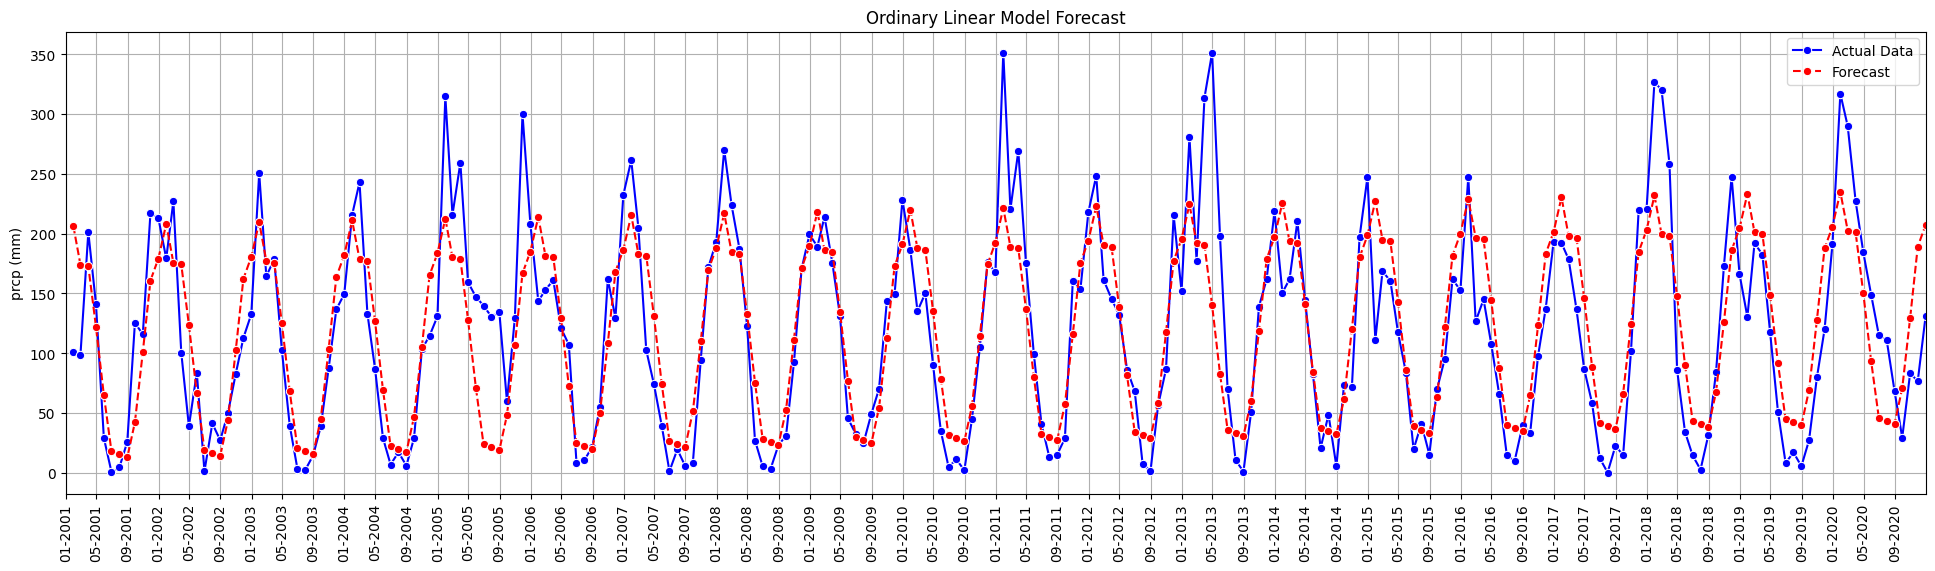

In [45]:
output = linear1.predict(monthly_data[features])
output_copy = pd.Series(output, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(monthly_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Linear Model Forecast")
plt.legend()
# plt.savefig('../forecast/monthly_ordinary_cubic_model.png')
plt.show()

Evaluate:

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(monthly_test['prcp'], output[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(monthly_test['prcp'], output[-60:])
r2 = r2_score(monthly_test['prcp'], output[-60:])
aic = linear1.aic
bic = linear1.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2554.62
RMSE: 50.54
MAE: 43.41
R²: 0.676
AIC: 1909.87
BIC: 1951.38


##### Quadratic model:

In [47]:
features = ['index', 'index2', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
linear2 = OLS(monthly_train['prcp'], monthly_train[features]).fit()
linear2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     30.96
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.01e-37
Time:                        11:32:21   Log-Likelihood:                -940.81
No. Observations:                 180   AIC:                             1910.
Df Residuals:                     166   BIC:                             1954.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.4994      0.268      1.865      0.064      -0.029       1.028
index2        -0.0021      0.001     -1.447      0.150      -0.005       0.001
m1           195.4590     15.412     12.683      0.000     165.031     225.887
m2           162.9153     15.444     10.549      0.000     132.424     193.407
m3           161.3597     15.475     10.427      0.000     130.807     191.912
m4           110.6557     15.504      7.137      0.000      80.045     141.267
m5            53.3906     15.533      3.437      0.001      22.723      84.058
m6             6.0970     15.560      0.392      0.696     -24.625      36.818
m7             3.4243     15.586      0.220      0.826     -27.349      34.197
m8             0.8092     15.611      0.052      0.959     -30.013      31.632
m9            30.1994     15.635      1.932      0.055      -0.670      61.069
m10           88.7140     15.658      5.666      0.000      57.800     119.628
m11          148.4285     15.679      9.467      0.000     117.472     179.385
m12          166.6110     15.700     10.612      0.000     135.615     197.607
==============================================================================
Omnibus:                       46.940   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.671
Skew:                           1.167   Prob(JB):                     3.08e-23
Kurtosis:                       5.893   Cond. No.                     1.48e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Nhiều biến không có ý nghĩa

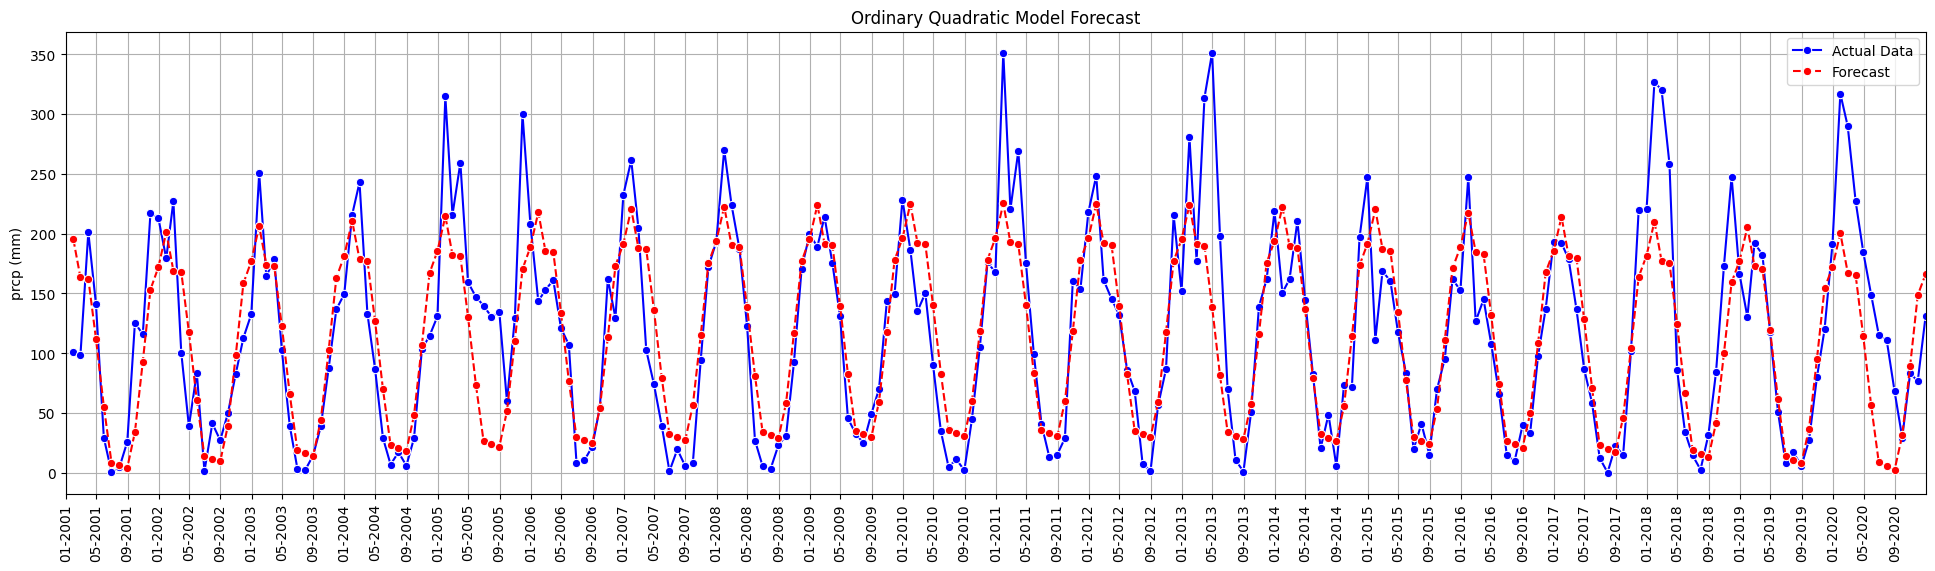

In [49]:
output2 = linear2.predict(monthly_data[features])
output2_copy = pd.Series(output2, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(monthly_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output2_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Quadratic Model Forecast")
plt.legend()
# plt.savefig('../forecast/monthly_ordinary_quadratic_model.png')
plt.show()

Evaluate:

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(monthly_test['prcp'], output2[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(monthly_test['prcp'], output2[-60:])
r2 = r2_score(monthly_test['prcp'], output2[-60:])
aic = linear2.aic
bic = linear2.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2753.16
RMSE: 52.47
MAE: 38.10
R²: 0.651
AIC: 1909.61
BIC: 1954.31


##### Cubic model:

In [51]:
features = ['index', 'index2', 'index3', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
linear3 = OLS(monthly_train['prcp'], monthly_train[features]).fit()
linear3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     28.58
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           5.72e-37
Time:                        11:35:18   Log-Likelihood:                -940.80
No. Observations:                 180   AIC:                             1912.
Df Residuals:                     165   BIC:                             1959.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.4383      0.670      0.654      0.514      -0.885       1.761
index2        -0.0012      0.009     -0.142      0.887      -0.018       0.016
index3     -3.187e-06    3.2e-05     -0.100      0.921   -6.64e-05       6e-05
m1           196.3048     17.636     11.131      0.000     161.484     231.126
m2           163.7716     17.715      9.245      0.000     128.794     198.749
m3           162.2263     17.793      9.117      0.000     127.095     197.358
m4           111.5327     17.870      6.241      0.000      76.249     146.816
m5            54.2779     17.946      3.025      0.003      18.845      89.711
m6             6.9945     18.021      0.388      0.698     -28.587      42.576
m7             4.3321     18.095      0.239      0.811     -31.396      40.061
m8             1.7273     18.169      0.095      0.924     -34.147      37.601
m9            31.1278     18.242      1.706      0.090      -4.891      67.146
m10           89.6527     18.315      4.895      0.000      53.491     125.815
m11          149.3777     18.387      8.124      0.000     113.073     185.683
m12          167.5706     18.460      9.078      0.000     131.123     204.018
==============================================================================
Omnibus:                       46.867   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.333
Skew:                           1.166   Prob(JB):                     3.64e-23
Kurtosis:                       5.887   Cond. No.                     2.98e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Nhiều biến không mang ý nghĩa trong mô hình

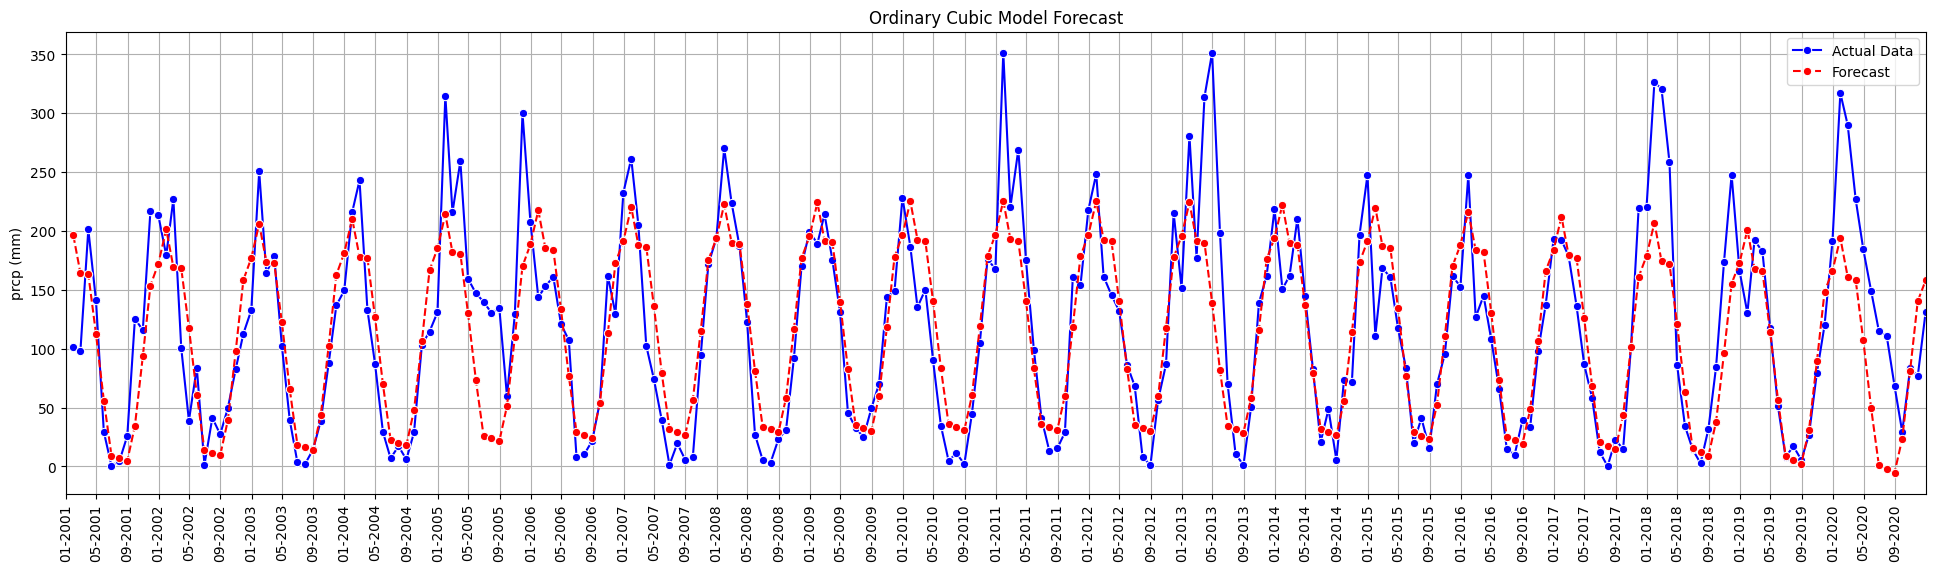

In [52]:
output3 = linear3.predict(monthly_data[features])
output3_copy = pd.Series(output3, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(monthly_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output3_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Cubic Model Forecast")
plt.legend()
# plt.savefig('../forecast/monthly_ordinary_cubic_model.png')
plt.show()

Evaluate:

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(monthly_test['prcp'], output3[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(monthly_test['prcp'], output3[-60:])
r2 = r2_score(monthly_test['prcp'], output3[-60:])
aic = linear3.aic
bic = linear3.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2940.68
RMSE: 54.23
MAE: 38.38
R²: 0.627
AIC: 1911.60
BIC: 1959.50
